### Import dataset to dataframe

Note that the dataset might be coming from BigQuery or from a query on the local database (created from the SE Data Dump). The two data sources should be interchangeable in the code.

In [1]:
import json
import os
import pandas as pd
from pathlib import Path

DATASET_FILE = "saved_dataset.csv"      # The file name of the saved dataset (saved on / loaded from local disk)
cwd = Path().absolute()                 # Current working directory (note: possibly different from execution directory)

# Load a saved copy of the dataset from local disk (if it exists)
try:
    dataset_path = os.path.join(cwd, DATASET_FILE)
    results = pd.read_csv(dataset_path)
    results = results.astype({"creation_date": "datetime64[ns]"})
    print("Saved copy of dataset loaded from local disk.")
except FileNotFoundError:
    print("Saved dataset not found!")

Saved copy of dataset loaded from local disk.


### Dataset analysis

In [2]:
import numpy as np

def get_basic_analysis(data_col):
    avg = np.mean(data_col)
    max = np.max(data_col)
    min = np.min(data_col)
    med = np.median(data_col)
    return avg, max, min, med

def print_basic_analysis(data_col, label):
    avg, max, min, med = get_basic_analysis(data_col)
    print("Stats for " + label + ":" )
    print("Average: " + f"{avg:,.2f}")
    print("Maximum: " + f"{max:,}")
    print("Minimum: " + str(min))
    print("Median: "  + str(med))
    print()

In [3]:
print_basic_analysis(results['view_count'], "view count")
print_basic_analysis(results['answer_count'], "answer count")
print_basic_analysis(results['question_score'], "question score")
print_basic_analysis(results['answer_score'], "answer score")

Stats for view count:
Average: 540.03
Maximum: 2,008,787
Minimum: 5
Median: 142.0

Stats for answer count:
Average: 1.38
Maximum: 60
Minimum: 1
Median: 1.0

Stats for question score:
Average: 0.59
Maximum: 1,729
Minimum: -19
Median: 0.0

Stats for answer score:
Average: 1.37
Maximum: 967
Minimum: 0
Median: 1.0



In [4]:
%pip install seaborn
import seaborn
#from matplotlib.ticker import ScalarFormatter
import matplotlib
from matplotlib.ticker import StrMethodFormatter
import math

# Temporarily override the figuresize using rc params
matplotlib.rcParams["figure.figsize"] = (8, 2)

def five_num_box(data, x_label):
    ax = seaborn.boxplot(data=data, orient="h", whis=math.inf)          # prevents unwanted outlier detection
    ax.set(xlabel=x_label)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    #ax.get_figure().savefig("Temp\\" + x_label + ".png")

def five_num_box_log(data, x_label):
    ax = seaborn.boxplot(data=data, orient="h", whis=math.inf)          # prevents unwanted outlier detection
    ax.set(xlabel=x_label)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))        # https://stackoverflow.com/a/46574866
    #ax.get_figure().savefig("Temp\\" + x_label + ".png")

def convertFiveFormat(series):
    listified = []
    listified.append(series["min"])
    listified.append(series["25%"])
    listified.append(series["50%"])
    listified.append(series["75%"])
    listified.append(series["max"])
    return listified

five_vc = results.view_count.describe()
five_ac = results.answer_count.describe()
five_qs = results.question_score.describe()
five_as = results.answer_score.describe()

Note: you may need to restart the kernel to use updated packages.


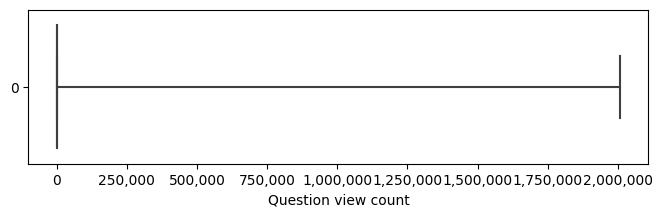

In [5]:
five_num_box(convertFiveFormat(five_vc), "Question view count")

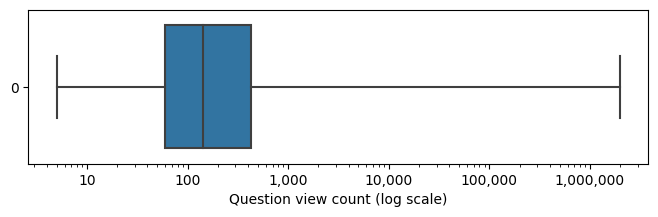

In [6]:
five_num_box_log(convertFiveFormat(five_vc), "Question view count (log scale)")

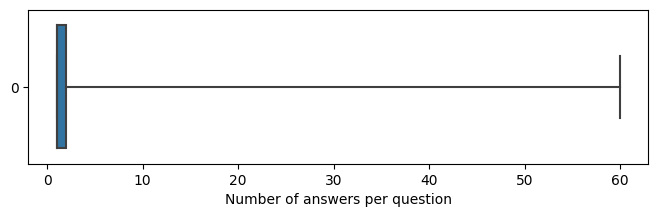

In [7]:
five_num_box(convertFiveFormat(five_ac), "Number of answers per question")

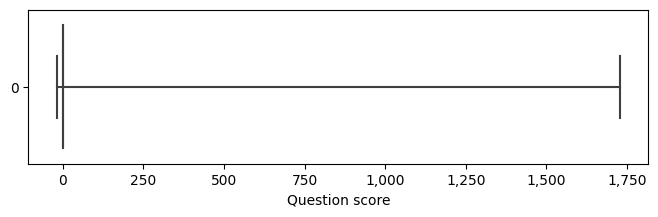

In [8]:
five_num_box(convertFiveFormat(five_qs), "Question score")

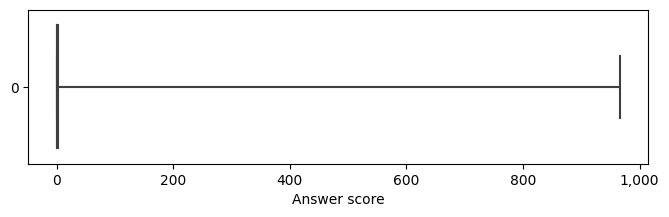

In [9]:
five_num_box(convertFiveFormat(five_as), "Answer score")

Note: because tags are stored differently between the BQ and DD data sources, the below code will only work with the DD source.

In [10]:
from collections import Counter

COUNT_RESULT = "tag_count.csv"  # the file name of the saved dataset (saved on / loaded from local disk)

# See if we already have a saved copy of the tag counting
try:
    count_path = os.path.join(cwd, COUNT_RESULT)
    tag_counts_df = pd.read_csv(count_path)
    print("Saved copy of tag count loaded from local disk.")

# If not, run the count (tested runtime on 9750-H was about an hour for full dataset!)
except FileNotFoundError:
    print("Saved copy of tag count (" + COUNT_RESULT + ") not found - running count...")

    # Count the tags
    tag_counter = Counter()
    all_tags = results["tags"].str.cat(sep='')      # Concatenate the tags together
    individual_tags = all_tags.split('<')           # Split into individual tags
    individual_tags = [tag.strip('>') for tag in individual_tags if tag]
    tag_counts = Counter(individual_tags)

    # Save the result to a CSV
    tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=["Tag", "Frequency"])
    tag_counts_df.to_csv(COUNT_RESULT, index=False)
    print("Tag count has been saved to local storage as a CSV: " + count_path)

Saved copy of tag count loaded from local disk.


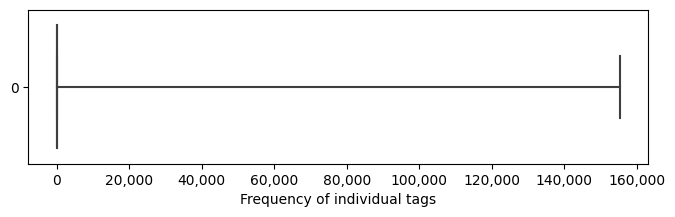

In [11]:
s = tag_counts_df.iloc[:,1]

temp = convertFiveFormat(s.describe())
five_num_box(temp, "Frequency of individual tags")

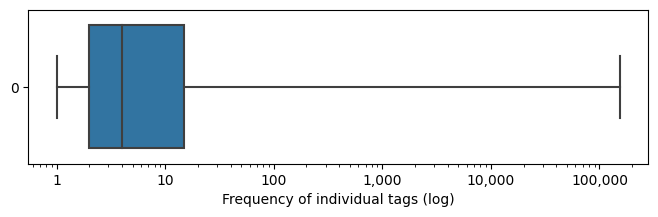

In [12]:
five_num_box_log(temp, "Frequency of individual tags (log)")

In [13]:
# Reset rc params
matplotlib.rc_file_defaults()